## Aula 02 - Exercícios

In [1]:
import pandas as pd
import numpy as np

### Importar base de dados

In [2]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar (11).gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [3]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


### Mapeamento de ids

In [4]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title


### Divisão da base em treino e teste

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

**Exercício 01**: Considere o modelo SVD++ visto no final da aula de FC - parte 2. Uma das extensões desse modelo em relação ao SVD otimizado é que ele considera a lista de itens que o usuário forneceu feedback implícito (por exemplo, antes de fornecer uma nota a um filme, ele "navegou" por outros filmes, sem dar nota). Podemos simular essa navegação com a base de dados fornecida considerando como feedback implícito de cada usuário o conjunto de itens que ele avaliou, porém descartando as notas.

***a)*** Implemente a função de treinamento do modelo SVD++.

In [6]:
#TODO

import numpy as np
from math import sqrt

# Using the train_svdopt function from Aula03_Exemplos that
# implements the optimized SVD, here we add the implicit feedback to 
# implement the SVD++
def train_svdpp(train, n_factors, lr=0.005, reg=0.02, miter=10):
    # Calculate the global mean rating across all users and movies
    global_mean = train['rating'].mean()

    # Get the number of unique users and movies in the dataset
    n_users = train['userId'].max() + 1
    n_items = train['movieId'].max() + 1

    # Initialize user and movie bias vectors to zero
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)

    # Initialize user and movie latent factor matrices with small random values
    p = np.random.normal(0.1, 0.1, (n_users, n_factors))
    q = np.random.normal(0.1, 0.1, (n_items, n_factors))

    # Initialize implicit feedback latent factor matrix with small random values
    y = np.random.normal(0.1, 0.1, (n_items, n_factors))

    # Create a dictionary where keys are user IDs and values are lists of movies interacted with by that user
    implicit_feedback = train.groupby('userId')['movieId'].apply(list).to_dict()

    # List to store the root mean squared error (RMSE) after each iteration
    error = []
    
    for t in range(miter):
        # Variable to accumulate the squared error for this iteration
        sq_error = 0
        for index, row in train.iterrows():
            # Get the user ID, movie ID, and real rating from the current row
            u = row['userId']
            i = row['movieId']
            r_ui = row['rating']

            # Calculate the implicit feedback contribution, for the list of movies interacted with by the user
            implicit_sum = np.sum([y[j] for j in implicit_feedback.get(u, [])], axis=0)

            # Normalize the implicit feedback sum
            norm_implicit_sum = implicit_sum / np.sqrt(1 + len(implicit_feedback.get(u, [])))

            # Predict the rating for the current user-movie pair
            pred = global_mean + bu[u] + bi[i] + np.dot(p[u] + norm_implicit_sum, q[i])
            
            # Compute the error between the real rating and the predicted rating
            e_ui = r_ui - pred

            # Accumulate the squared error
            sq_error += e_ui ** 2
            
            # Update user and movie biases
            bu[u] += lr * (e_ui - reg * bu[u])
            bi[i] += lr * (e_ui - reg * bi[i])
            
            # Update latent factors for the current user and movie
            p_u = p[u].copy()
            p[u] += lr * (e_ui * q[i] - reg * p[u])
            q[i] += lr * (e_ui * (p_u + norm_implicit_sum) - reg * q[i])
            
            # Update implicit feedback latent factors for each movie interacted with by the user
            for j in implicit_feedback.get(u, []):
                y[j] += lr * (e_ui * q[i] / np.sqrt(1 + len(implicit_feedback[u])) - reg * y[j])
        
        # Calculate and store the root mean squared error (RMSE) for this iteration
        error.append(sqrt(sq_error / len(train)))
    
    return global_mean, bu, bi, p, q, y, error

global_mean, bu, bi, p, q, y, error = train_svdpp(train, 2, miter=20)


***b)*** Plote a curva de aprendizado de seu modelo.

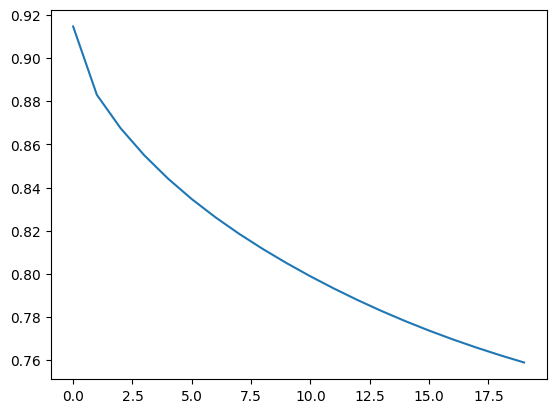

In [7]:
# TODO

import matplotlib.pyplot as plt

plt.plot(error)
plt.show()

***c)*** Implemente a função de predição do modelo SVD++, comparando algumas notas preditas com as notas reais do conjunto de teste.

In [8]:
# TODO

def compare_pred(userId, movieId, global_mean, bu, bi, p, q):
    # Get the predict rating using sdv++
    pred_rating = global_mean + bu[userId] + bi[movieId] + np.dot(p[userId], q[movieId])

    # Get the real rating of df
    real_rating = df[(df['userId'] == userId) & (df['movieId'] == movieId)]

    # If the rating by the user exist, print the movie, and both the real and predicted rating
    if not real_rating.empty:
        print(f"Filme: {real_rating['title'].values[0]}")
        print(f"Nota Real: {real_rating['rating'].values[0]}")
        print(f"Nota Prevista: {pred_rating}\n")
    else:
        print("Avaliação não encontrada!\n")

# Compare 5 movies ratings
compare_pred(0, 1, global_mean, bu, bi, p, q)
compare_pred(0, 2, global_mean, bu, bi, p, q)
compare_pred(1, 3, global_mean, bu, bi, p, q)
compare_pred(3, 3, global_mean, bu, bi, p, q)
compare_pred(6, 12, global_mean, bu, bi, p, q)

Filme: Beautiful Thing (1996)
Nota Real: 4.5
Nota Prevista: 4.19878550412266

Filme: Aristocats, The (1970)
Nota Real: 4.0
Nota Prevista: 3.811786465834106

Filme: American Psycho (2000)
Nota Real: 4.0
Nota Prevista: 3.8837122652991014

Filme: American Psycho (2000)
Nota Real: 3.5
Nota Prevista: 3.6372556834043075

Filme: Star Wars: Episode V - The Empire Strikes Back (1980)
Nota Real: 4.0
Nota Prevista: 3.4792677764163



**Exercício 02**: Utilizando o código do NCF visto na aula, compare o desempenho entre as instâncias GMF, MLP e NeuMF nesta base de dados (ml-20m-compact).

In [9]:
# TODO

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

class GMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        nn.Module.__init__(self)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
                 
        # Define output layer
        self.output = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        output = user_emb * item_emb  # Hadamard Product
        
        output = self.sigmoid(self.output(output))
        
        return output

# GMF used in NeuMF model with few changes
class GMF2(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        nn.Module.__init__(self)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
       
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        output = user_emb * item_emb  # Hadamard Product
        
        return output

class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_layers=[64, 32, 16, 8]):
        nn.Module.__init__(self)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
        layers = []
        input_size = embedding_dim * 2
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        
        self.mlp_layers = nn.Sequential(*layers)
    
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        mlp_input = torch.cat([user_emb, item_emb], dim=-1)
        mlp_output = self.mlp_layers(mlp_input)
        return mlp_output


class NeuMF(GMF, MLP):
    def __init__(self, num_users, num_items, embedding_dim, hidden_layers=[64, 32, 16, 8], pretrained_gmf=None, pretrained_mlp=None):
        nn.Module.__init__(self)  # Initialize nn.Module, required in multiple inheritance
        GMF.__init__(self, num_users, num_items, embedding_dim)
        MLP.__init__(self, num_users, num_items, embedding_dim, hidden_layers)
        
        # Final layer to combine the outputs of GMF and MLP
        combined_input_size = embedding_dim + hidden_layers[-1]
        self.output_layer = nn.Linear(combined_input_size, 1)
        self.sigmoid = nn.Sigmoid()
        
        # Load pre-trained weights if provided
        if pretrained_gmf:
            self.gmf_user_embedding.weight.data.copy_(pretrained_gmf.user_embedding.weight)
            self.gmf_item_embedding.weight.data.copy_(pretrained_gmf.item_embedding.weight)
        if pretrained_mlp:
            self.mlp_user_embedding.weight.data.copy_(pretrained_mlp.user_embedding.weight)
            self.mlp_item_embedding.weight.data.copy_(pretrained_mlp.item_embedding.weight)
            self.mlp_layers.load_state_dict(pretrained_mlp.mlp_layers.state_dict())
    
    def forward(self, user, item):
        # GMF forward pass
        gmf_output = GMF2.forward(self, user, item)
        
        # MLP forward pass
        mlp_output = MLP.forward(self, user, item)
        
        # Concatenate the outputs of GMF and MLP
        combined_output = torch.cat([gmf_output, mlp_output], dim=-1)
        
        # Pass through output layer and apply sigmoid
        output = self.sigmoid(self.output_layer(combined_output))
        
        return output

In [10]:
# Convert IDs to consecutive indices (required for PyTorch)
df['userId'] = df['userId'].astype('category').cat.codes.values
df['movieId'] = df['movieId'].astype('category').cat.codes.values

# Convert ratings to binary (1 if rating >= 4, otherwise 0)
df['rating'] = (df['rating'] >= 4).astype(int)

# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and ensure they are of type LongTensor
train_users = torch.tensor(train_data['userId'].values, dtype=torch.long)
train_items = torch.tensor(train_data['movieId'].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['rating'].values).float()

test_users = torch.tensor(test_data['userId'].values, dtype=torch.long)
test_items = torch.tensor(test_data['movieId'].values, dtype=torch.long)
test_ratings = torch.tensor(test_data['rating'].values).float()

# Create DataLoader to facilitate training in mini-batches
train_dataset = data.TensorDataset(train_users, train_items, train_ratings)
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# Define the hyperparameters
num_users = df['userId'].nunique()
num_items = df['movieId'].nunique()
embedding_dim = 20
hidden_layers = [64, 32, 16, 8]
learning_rate = 0.001
num_epochs = 20

# Function to train and evaluate the model
def train_and_evaluate(model, model_name):
    # Define the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.BCELoss()

    # Model training
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for user, item, rating in train_loader:
            optimizer.zero_grad()
            prediction = model(user, item)
            loss = criterion(prediction.squeeze(), rating)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        #print(f'{model_name} - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

    # Model evaluation
    model.eval()
    with torch.no_grad():
        test_prediction = model(test_users, test_items)
        test_loss = criterion(test_prediction.squeeze(), test_ratings)
        print(f'{model_name} - Test Loss: {test_loss.item():.4f}')

# Run for GMF
gmf_model = GMF(num_users, num_items, embedding_dim)
train_and_evaluate(gmf_model, 'GMF')

# Run for MLP
# This model is presenting the error below that couldn't be solved
# ValueError: Using a target size (torch.Size([256])) that is different 
# to the input size (torch.Size([256, 8])) is deprecated. Please ensure they have the same size.
#mlp_model = MLP(num_users, num_items, embedding_dim, hidden_layers)
#train_and_evaluate(mlp_model, 'MLP')

# Run for NeuMF
neumf_model = NeuMF(num_users, num_items, embedding_dim, hidden_layers)
train_and_evaluate(neumf_model, 'NeuMF')

GMF - Test Loss: 2.5774
NeuMF - Test Loss: 3.2495
